# **Credit Card Fraud Analysis**



Note: When rerunning the code blocks, you may get slightly different numbers, since we cannot fully set the random seed for each session. However, the pattern of the output should be roughly the same.

For this project, we are analyzing a dataset (source: https://www.kaggle.com/datasets/kartik2112/fraud-detection) that stores data from several transactions with credit cards. The transactions occured between 2019/01/01 and 2020/12/31, and are focused in the United States. We can imagine that we are hired by a credit card company to take their dataset and find the best algorithm to classify each transaction as fraudulant or non-fraudulant for future use.

Doing this task succesfully and accurately is important for the following reasons:

- Properly identifying transactions will help protect customers from unauthorized charges and ensure that customers trust the credit card company and not switch to another, which would otherwise cause a loss in revenue
- Missing fraudulant transactions can be costly, so minimizing the amount lost will therefore miniminize losses.
- Similarly, missing non fraudulant transactions can be costly (generally not to the extent of fraudulant transactions however), since it will be annoying to customers if a bank constantly flags legitmate transactions and closes one's credit card.
- Optimizing the right patterns and trends in fraudulant transactions can improve risk management strategies. A company can then take proactive measures to mitigate future risks and stay within any potential regulations of data security.
- And in general, incorrect classiifcation could lead to a bad reputation for a credit card company overall.

Libaries used for visualization and data wrangling:

In [ ]:
import numpy as np
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# edit file paths as necessary

file_path = "/content/fraudTrain.csv" # importing the training dataset
traindf = pd.read_csv(file_path)
file_path = "/content/fraudTest.csv" # importing the testing dataset
testdf = pd.read_csv(file_path)
# combining both datasets; we will do our own train/test split later
df = pd.concat([traindf, testdf], axis=0)

df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


Below is a table describing each variable in the original dataset:

| Variable Name | Description of Variable |
|:--------:|:--------:|
|  trans_date_trans_time |  Transaction Date & Time  |  
|  cc_num   |  Credit card number   |
|  merchant   |  Merchant name   |
|  category  |  Category of Merchant  |  
|  amt   | Amount in Transaction |
|  first  |  First name of credit card holder |
|  last |  Last name of credit card holder  |
|  gender  |  Gender of credit card holder  |  
|  street  |  Street of of credit card holder |
|  city   |  City of credit card holder  |
| state   |  State of credit card holder  |  
|  zip  |  Zip code of credit card holder  |
|  lat  |  Latitude of credit card holder   |
| long  |  Longitude of credit card holder   |  
|  city_pop |  City population of credit card holder |
|  job |  Credit Card holder’s occupation   |
| dob  |  Date of Birth of Credit Card holder   |  
|  trans_num |  Transaction number   |
|  unix_time |  Transaction Date & Time in unix   |
| merch_lat  |  Latitude of merchant  |  
|  merch_long |  Longitude of merchant   |
|  is_fraud |  1 if fraud, 0 if not  |


# Part 1: Exploratory Data Analysis

We will do some data wrangling to get our data in a better format for model building and visualization:


In [ ]:
# drop unimportant variables
df.drop(['first','last','street','Unnamed: 0'], axis=1, inplace = True)

#recode time to a nicer format
df['trans_date_trans_time'] = pd.to_datetime(df.trans_date_trans_time,
                                             format='%Y-%m-%d %H:%M:%S')
df['hour'] = df['trans_date_trans_time'].dt.hour #extract hour
df['month'] = df['trans_date_trans_time'].dt.month #extract month

# get age of each person based on their date of birth
now = pd.Timestamp('now')
df['dob'] = pd.to_datetime(df.dob, format='%Y-%m-%d')    # 1
df['dob'] = df['dob'].where(df['dob'] < now,
                            df['dob'] -  np.timedelta64(100, 'Y'))   # 2
df['age'] = (now - df['dob']).astype('<m8[Y]')    # 3

df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,state,zip,lat,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,month,age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,28654,36.0788,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1,36.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,99160,48.8878,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1,45.0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,83252,42.1808,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1,62.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,59632,46.2306,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1,57.0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,24433,38.4207,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1,37.0


We will generate a correlation matrix of all the numerical variables:

In [ ]:
correlation_matrix = df.corr()
fraud_correlation = correlation_matrix['is_fraud']
fraud_correlation

<ipython-input-4-d6a9c2d59a28>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


cc_num       -0.001125
amt           0.209308
zip          -0.002190
lat           0.002904
long          0.001022
city_pop      0.000325
unix_time    -0.013329
merch_lat     0.002778
merch_long    0.000999
is_fraud      1.000000
hour          0.013196
month        -0.016417
age           0.011156
Name: is_fraud, dtype: float64

We can see that the `amt` variable has a weak positive correlation with regarding whether a transaction is fraudulant, which is expected behavior. Given that we are trying to classify data and the other correlations are too small, we will ignore their correlations as they are not significant.

Let's see how much of our data contains fraudulant transactions:

In [ ]:
df["is_fraud"].value_counts().rename_axis('Fraud Status').reset_index(name='counts')

,Fraud Status,counts
0,0,1842743
1,1,9651


The vast majority of our transactions in our dataset are **not** fraudulant,  which raises some minor concerns with having imbalanced data. This would otherwise make our models inaccurate; We will deal with this later.

**We will generate some visualizations with some of our variables against the fraduluant status now to see if any variables are good predictors by themselves:**

## Amount

First, we plot a scatterplot of the amount of each transaction against fraud status:

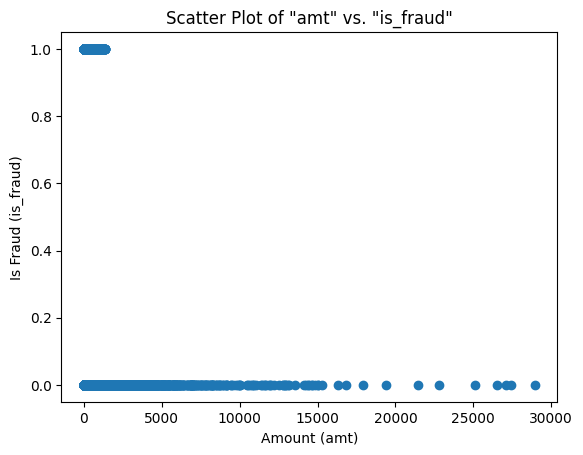

In [ ]:
# Scatter plot of "amt" vs. "is_fraud"
plt.scatter(df['amt'], df['is_fraud'])
plt.xlabel('Amount (amt)')
plt.ylabel('Is Fraud (is_fraud)')
plt.title('Scatter Plot of "amt" vs. "is_fraud"')
plt.show()

We can see that all the fraudulant transactions in our data have a transaction amount  less than 1,500 USD. Let's see the reletive percentages with the transactions that have an amount less than $1,500.

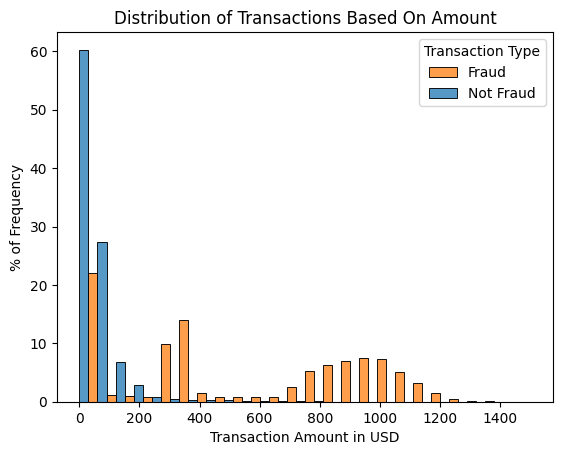

In [ ]:
# Create a histogram of "amt" for fraud and non-fraud cases

ax=sns.histplot(x = 'amt', data=df[df.amt<=1500], hue ='is_fraud', stat ='percent',
                multiple ='dodge', common_norm = False,  bins = 25)

ax.set_ylabel('% of Frequency')
ax.set_xlabel('Transaction Amount in USD')
ax.set_title("Distribution of Transactions Based On Amount")
plt.legend(title='Transaction Type', labels=['Fraud', 'Not Fraud'])

As what one may initially expect, the transactions with the higher amounts tend to be fraudulant, at least for those that are less than $1,500 with our dataset. A lack of more data for fraudulant transactions limits us from making any further observations with the amount.

## Time

We plot hour of day against the frequency of both fradulant and not fraudulant transactions separetely to avoid overplotting:

Text(0.5, 1.0, 'Fraudulant Transactions Frequency Based On Time of Day (Hour)')

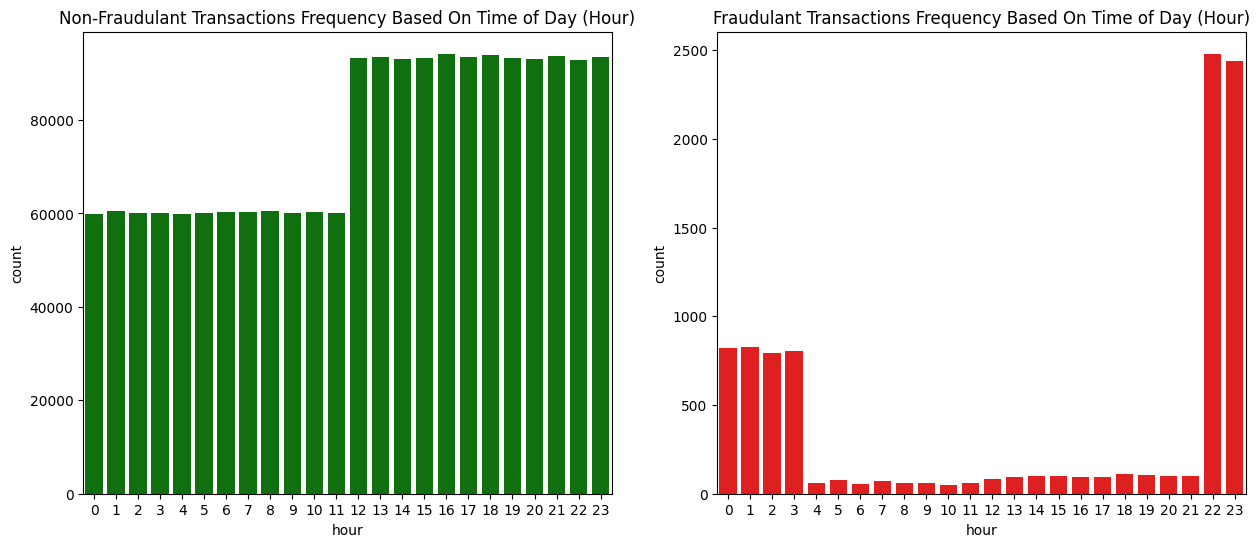

In [ ]:
# Plot count plots separately for fraud/non fraud transctions,
# displaying proportion of transactions based on hour

fraudData = df[df['is_fraud'] == 1]
nonFraudData = df[df['is_fraud'] == 0]

#skeleton of figure output layout
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6), sharey = False)

ax1 = sns.countplot(x = 'hour', data = nonFraudData, ax = ax1, color = "green")
ax2 = sns.countplot(x = 'hour', data = fraudData, ax = ax2, color = "red")

ax1.set_title("Non-Fraudulent Transactions Frequency Based On Time of Day (Hour)")
ax2.set_title("Fraudulent Transactions Frequency Based On Time of Day (Hour)")

We can see that while non fradulant transactions are evenly spread across the time of day, most of the fradulant transactions occur in the late evening/early morning of the day.

Do we see similar behavior if we focus on the month of transaction?

Text(0.5, 1.0, 'Fraudulant Transactions Frequency Based On Time of Day (Month)')

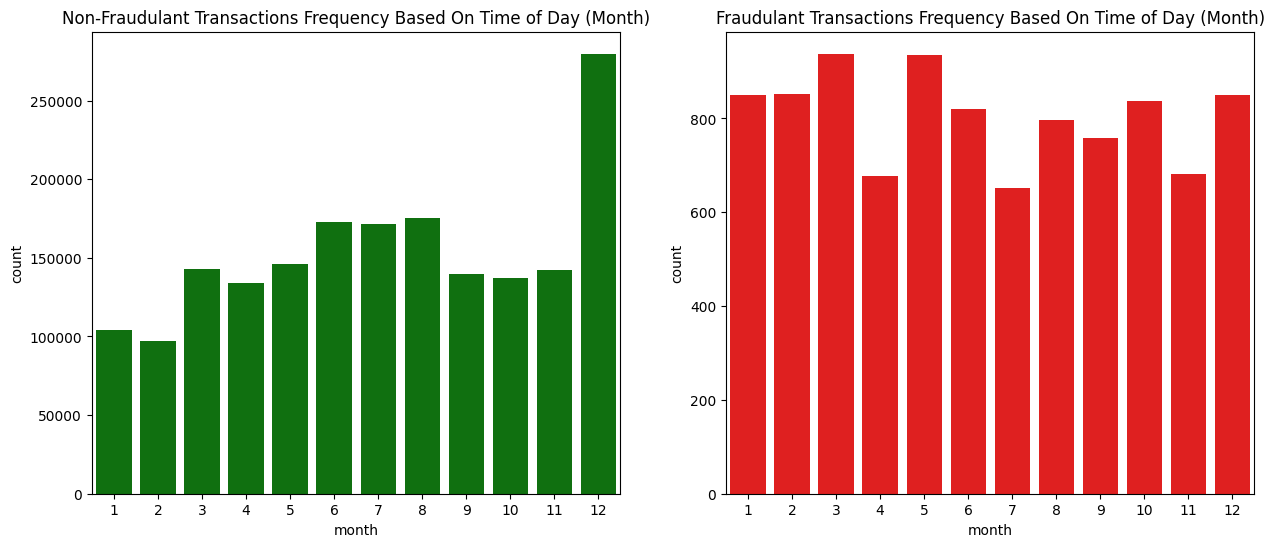

In [ ]:
# Plot count plots separately for fraud/non fraud transctions
# displaying proportion of transactions based on month

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6), sharey = False)

ax1 = sns.countplot(x = 'month', data = nonFraudData, ax = ax1, color = "green")
ax2 = sns.countplot(x = 'month', data = fraudData, ax = ax2, color = "red")

ax1.set_title("Non-Fraudulent Transactions Frequency Based On Time of Day (Month)")
ax2.set_title("Fraudulent Transactions Frequency Based On Time of Day (Month)")

Month does not seem to be a notable indicator. The spike in non-fraudulant transactions in December can most likely be explained from people purchasing more during the holiday season.

## Category

Now, we see if any type of purchase tends to result in a fradulant transaction:

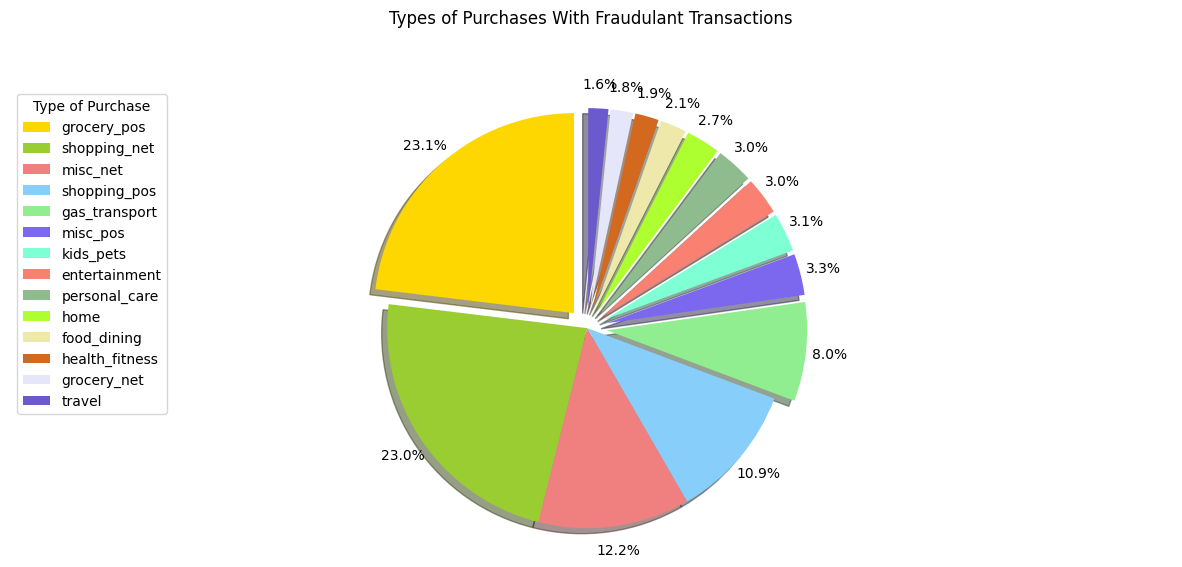

In [ ]:
# Plot a piechart to display the proportion of categories for fraudulant purchases

# ratio for each continent with which to offset each wedge.
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen',
               'mediumslateblue', 'aquamarine', 'salmon', 'darkseagreen',
               'greenyellow', 'palegoldenrod', 'chocolate', 'lavender', 'slateblue']

explode_list = [0.1, 0, 0, 0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

fraudData['category'].value_counts().plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%',
                            startangle=90,
                            shadow=True,
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center
                                              # of each pie slice and the start
                                          # of the text generated by autopct
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents)
                    )

# scale the title up by 12% to match pctdistance
plt.title("Types of Purchases With Fraudulant Transactions", y=1.12)
plt.axis('equal')
# add legend
categoryValues = fraudData['category'].value_counts().reset_index().rename(columns={"index": "categories", 0: "values"})
plt.legend(labels = categoryValues['categories'], loc='upper left',
           title='Type of Purchase')
plt.ylabel(None) # get rid of otherwise unnecessary y axis label
plt.show()

With fraudulant transactions, the bulk of them are related to grocery, shopping networks, and transportation.

Let us view the distribution when compared to non-fraudulant transactions:

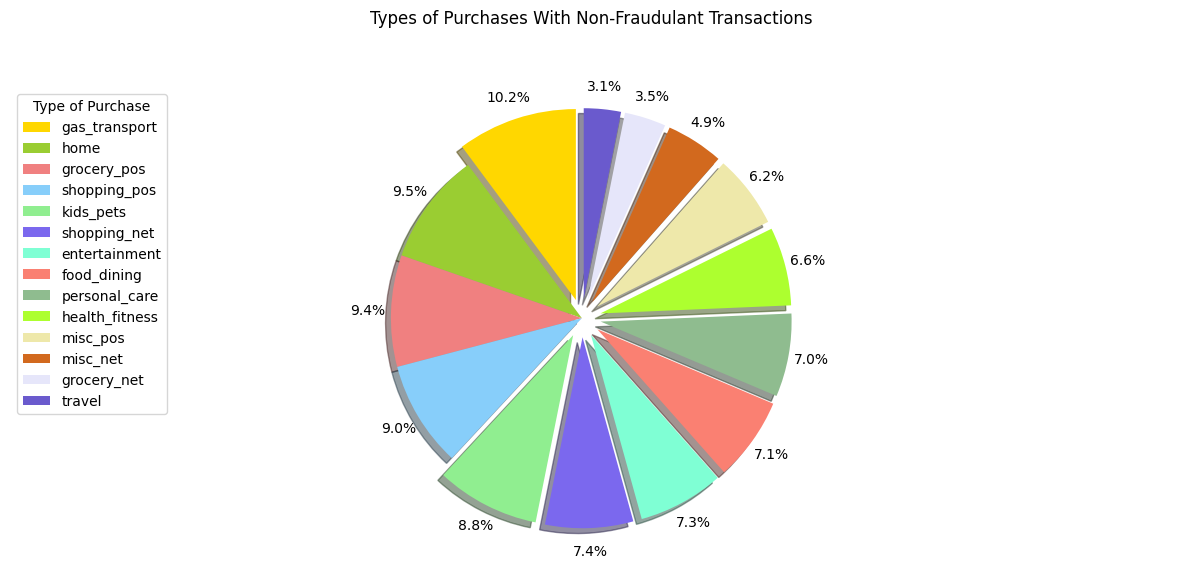

In [ ]:
# Plot a piechart to display proportions of categories for non-fraudulant purchases

colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen',
               'mediumslateblue', 'aquamarine', 'salmon', 'darkseagreen', 'greenyellow',
               'palegoldenrod', 'chocolate', 'lavender', 'slateblue']
explode_list = [0.1, 0, 0, 0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

nonFraudData['category'].value_counts().plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%',
                            startangle=90,
                            shadow=True,
                            labels=None,
                            pctdistance=1.12,
                            colors=colors_list,
                            explode=explode_list
                    )

# scale the title up by 12% to match pctdistance
plt.title("Types of Purchases With Non-Fraudulant Transactions", y=1.12)
plt.axis('equal')
# add legend
categoryValues = nonFraudData['category'].value_counts().reset_index().rename(columns={"index": "categories", 0: "values"})
plt.legend(labels = categoryValues['categories'], loc='upper left',
           title='Type of Purchase')
plt.ylabel(None) # get rid of otherwise unnecessary y axis label
plt.show()

We can see that there is clearly a more even distribution of the types of purchases for non-fraudulant transactions.

## City Population

Do fraudulant transactions happen in more populated areas?

Text(0.5, 1.0, 'City Population Distribution For Fraud Cases')

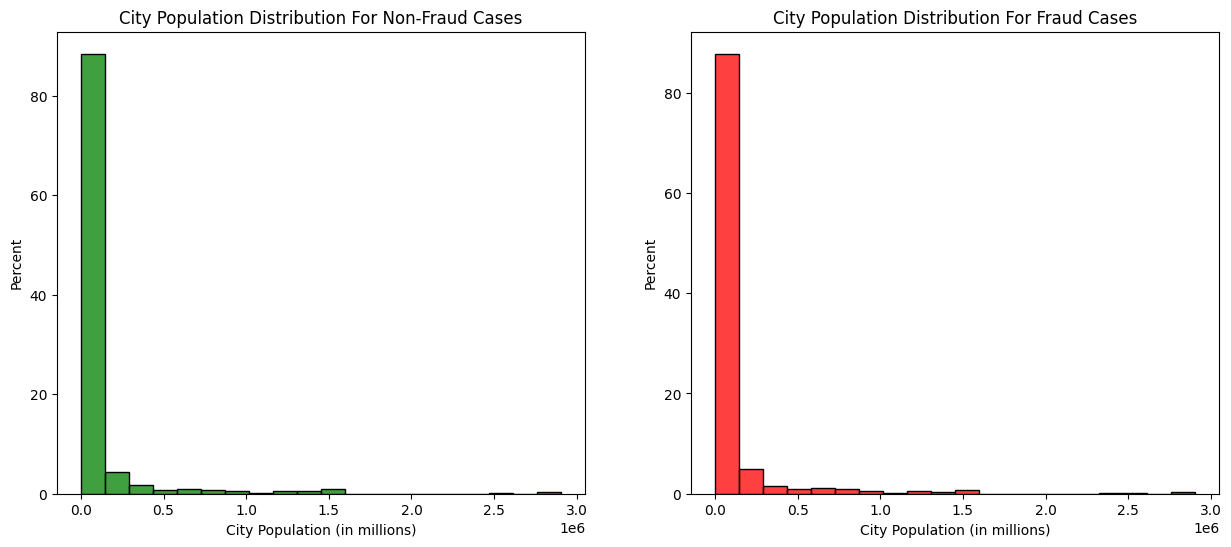

In [ ]:
# plot histograms of city population in millions, split by fraud status

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6), sharey = False)
ax1 = sns.histplot(x = 'city_pop', data = nonFraudData, stat = "percent",
                   bins = 20, ax = ax1, color = "green")
ax2 = sns.histplot(x = 'city_pop', data = fraudData, stat = "percent",
                   bins = 20, ax = ax2, color = "red")

ax1.set_xlabel('City Population (in millions)')
ax2.set_xlabel('City Population (in millions)')
ax1.set_title("City Population Distribution For Non-Fraud Cases")
ax2.set_title("City Population Distribution For Fraud Cases")

There is quite a bit of overlap; We see similar proportions in non fraudulant and fraudulant cases for all ranges in the city population. Thus, it is not a good indicator by itself for potentially indicating fraud status.

## Gender

Is one gender more likely to have fradulant activites vs another?

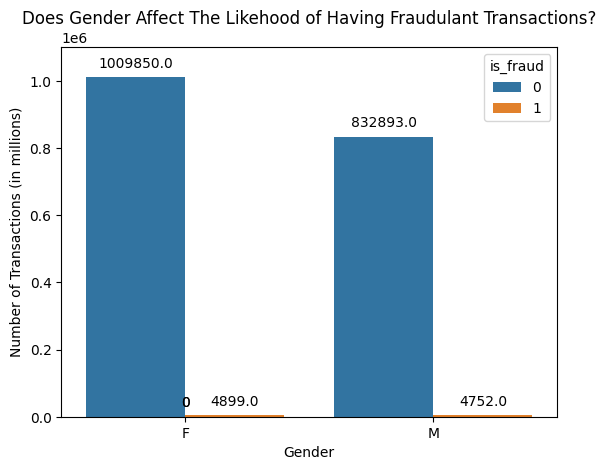

In [ ]:
# plot bar graph displaying the number of fraud/non fraud transactions, split by gender

ax = sns.countplot(x = "gender", hue = "is_fraud", data = df)

plt.title("Does Gender Affect The Likehood of Having Fraudulant Transactions?")
plt.xlabel("Gender")
plt.ylabel("Number of Transactions (in millions)")
plt.ylim(0, 1100000)

# Add values on top of each bar for clarity
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

We can see that females generally have more transactions, but males tend to have slightly more fraudulant transactions, though the margin is not very high. Gender is not a good indicator by itself to predict fraud status.

## Age

Now lets see if there is a specific age range where fraudulant transactions happen more often. We againsplit up the data based on fraud status to avoid overplotting:

Text(0, 0.5, 'Proportion of Frequency')

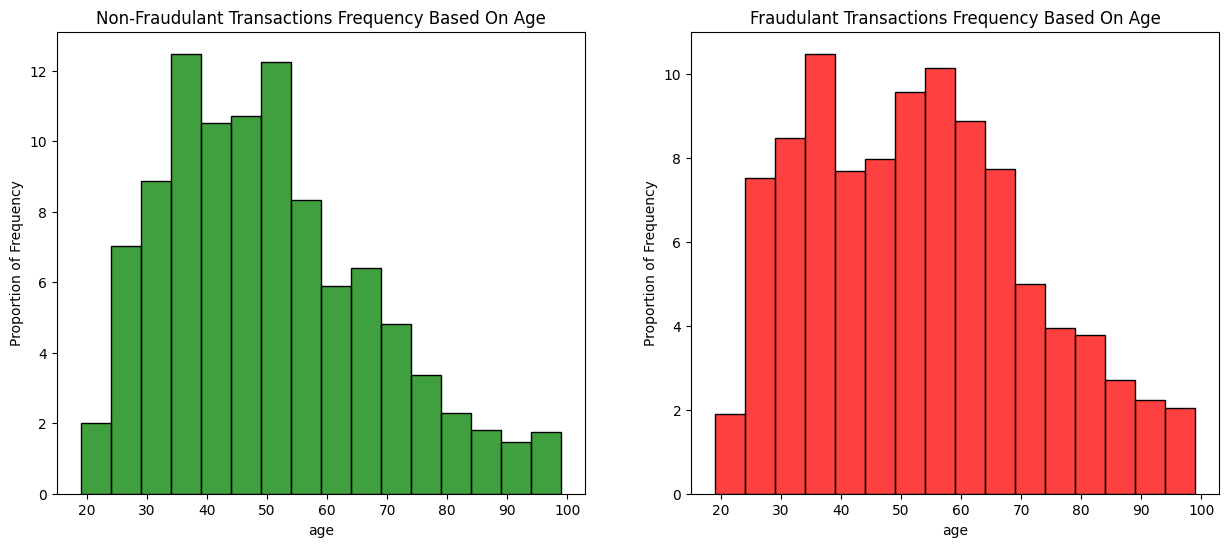

In [ ]:
# Plot histograms split by fraud status, displaying age vs the proportion of transactions

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6), sharey = False)

ax1 = sns.histplot(x = 'age', data = nonFraudData, stat = "percent", binwidth = 5,
                   bins = 20, ax = ax1, color = "green")
ax2 = sns.histplot(x = 'age', data = fraudData, stat = "percent", binwidth = 5,
                   bins = 20, ax = ax2, color = "red")

ax1.set_title("Non-Fraudulant Transactions Frequency Based On Age")
ax2.set_title("Fraudulant Transactions Frequency Based On Age")
ax1.set_ylabel('Proportion of Frequency')
ax2.set_ylabel('Proportion of Frequency')

It does not appear that there is a significance in the age of the card holder in terms of predicting if transactions are fraudulant.

## Latitude/Longitude

Finally, we will see if merchant location and/or card holder location appears to cluster around any certain areas for fraud. We split up each graph as to avoid overplotting.


Text(0, 0.5, 'Seller Longitude Location')

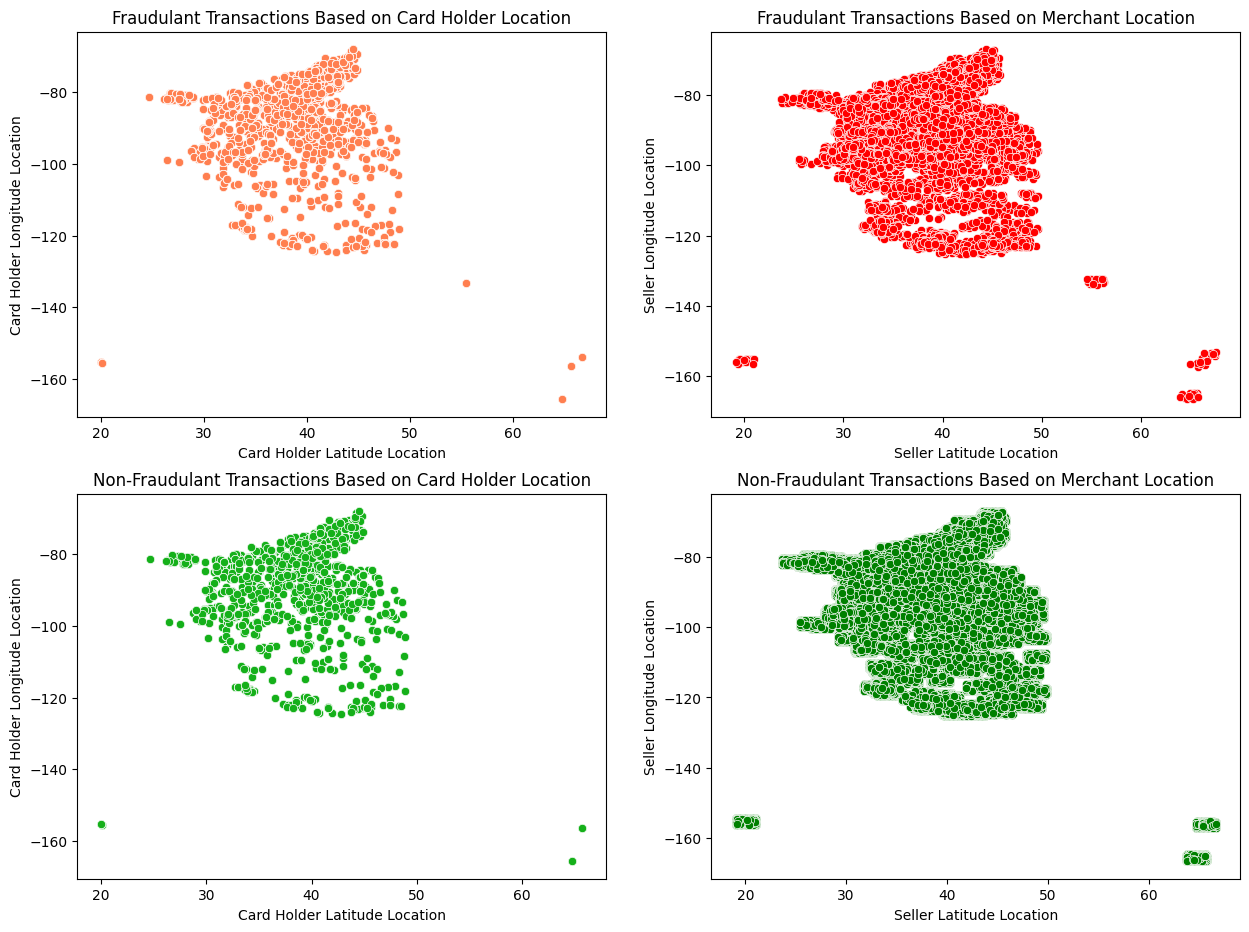

In [ ]:
# Plot four different scatterplots split by lat/long and merch_lat/merch_long and fraud status

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 11), sharey = False)
ax1 = sns.scatterplot(data = fraudData, x = 'lat', y = 'long', ax = ax1, color = "coral")
ax2 = sns.scatterplot(data = fraudData, x = 'merch_lat', y = 'merch_long', ax = ax2, color = "red")
ax3 = sns.scatterplot(data = nonFraudData, x = 'lat', y = 'long', ax = ax3, color = "#15B01A")
ax4 = sns.scatterplot(data = nonFraudData,x = 'merch_lat', y = 'merch_long', ax = ax4, color = "green")

ax1.set_title("Fraudulant Transactions Based on Card Holder Location")
ax2.set_title("Fraudulant Transactions Based on Merchant Location")
ax3.set_title("Non-Fraudulant Transactions Based on Card Holder Location")
ax4.set_title("Non-Fraudulant Transactions Based on Merchant Location")
ax1.set_xlabel('Card Holder Latitude Location')
ax2.set_xlabel('Seller Latitude Location')
ax3.set_xlabel('Card Holder Latitude Location')
ax4.set_xlabel('Seller Latitude Location')
ax1.set_ylabel('Card Holder Longitude Location')
ax2.set_ylabel('Seller Longitude Location')
ax3.set_ylabel('Card Holder Longitude Location')
ax4.set_ylabel('Seller Longitude Location')

From first glance, there is a lot of overlap with our datapoints, which suggests that all transactions between the credit card holder and merchant occur in the same general location. In particular, the bulk of transactions occur in the NE region of the US.

However, there are clearly less datapoints displayed for card holder location, implying that more than one  transaction (regardless if it is fraudulant) happens on the same card, which makes sense; People will make different purchases with different sellers.

Overall, it does not seem that location is not a good indicator by itself at determining if a transaction is fraudulant.

*Note that the points at the bottom corners of the plots are not outliers; Both of them corresponding to Alaska and Hawaii, which are farther away in promixity with the other US states.*

In conclusion from our EDA, we can see that category, amount, and time seem to be the most significant factors in determining whether a transaction is fraudulant or not.

# Part 2: Model Building & Validation

We will try and set the seed for reproducible results:

In [ ]:
import random
random_seed = 54
np.random.seed(random_seed)
random.seed(random_seed)

We will do some more data wrangling before we build our models. This involves us randomizing the order of the observations, since there may be biased due to them being in order based on the time of transaction. Additionally, we drop some more unnecessary variables and convert the remaining qualitiative variables into dummy variables.

In [ ]:
df = df.sample(frac=1).reset_index(drop=True) # randomize order of observations to avoid bias
# drop unimportant variables
df.drop(['merchant', 'cc_num', 'city', 'state', 'zip', 'trans_num', 'job', 'dob', 'unix_time',
         'trans_date_trans_time', 'merch_lat', 'merch_long', 'lat', 'long'], axis=1, inplace = True)
df = pd.get_dummies(df, columns = ['category', 'gender']) #creates dummy variables for the qualitative variables
df.head()

,amt,city_pop,is_fraud,hour,month,age,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,...,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M
0,11.70,18459,0,3,9,95.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,31.52,513,0,6,7,47.0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,34.54,276002,0,19,3,73.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,9.58,215,0,3,7,55.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,28.42,5726,0,17,6,76.0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


Checking correct datatypes:

In [ ]:
df.dtypes

amt                        float64
city_pop                     int64
is_fraud                     int64
hour                         int64
month                        int64
age                        float64
category_entertainment       uint8
category_food_dining         uint8
category_gas_transport       uint8
category_grocery_net         uint8
category_grocery_pos         uint8
category_health_fitness      uint8
category_home                uint8
category_kids_pets           uint8
category_misc_net            uint8
category_misc_pos            uint8
category_personal_care       uint8
category_shopping_net        uint8
category_shopping_pos        uint8
category_travel              uint8
gender_F                     uint8
gender_M                     uint8
dtype: object

All our variables are coded into numerical form, so we will not change the datatypes for any variables.

We are going to use **downsampling** to help deal with the issue of our imbalanced data. This reduces the number of observations that are not fraudulant to help avoid our models being biased by taking a random sample. We also split up our data into our independent and dependent variables.

In [ ]:
from sklearn.utils import resample

# We rerun these to update to the changes we have done above
fraudData = df[df['is_fraud'] == 1] #only get observations related to fraudulant transactions
nonFraudData = df[df['is_fraud'] == 0] #only get observations related to non-fraudulant transactions

nonFraudData = resample(nonFraudData, replace = False, n_samples = len(fraudData), random_state = random_seed)
down_samples = pd.concat([fraudData, nonFraudData], axis = 0) # create a new training dataset with the downscaled data

Y = down_samples['is_fraud']
X = down_samples.drop(['is_fraud'], axis = 1)

Now that the training and testing data is all formatted, we will import the libraries and define any additional functions for model building/analysis. We also go ahead and split our data into training and testing datasets.

In [ ]:
 # Allows us to test parameters of classification algorithms and find the best one
 from sklearn.model_selection import GridSearchCV
 # Logistic Regression classification algorithm
 from sklearn.linear_model import LogisticRegression
 # Support Vector Machine classification algorithm
 from sklearn.svm import SVC
 # Decision Tree classification algorithm
 from sklearn.tree import DecisionTreeClassifier
 # K Nearest Neighbors classification algorithm
 from sklearn.neighbors import KNeighborsClassifier
 # LDA/QDA classification algorithm
 from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
 # Random forest classification algorithm
 from sklearn.ensemble import RandomForestClassifier
 # XGboost classification algorithm
 import xgboost as xgb

 # To split our data into training and testing data
 from sklearn.model_selection import train_test_split
 # To get the precision and recall values
 from sklearn.metrics import classification_report

def plot_confusion_matrix(y,y_predict, title):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, cmap = "YlGnBu", annot=True, ax = ax, fmt = "d"); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix For {title} Model');
    ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])
    plt.show()

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.2, random_state = random_seed)
print ('Train set:', Xtrain.shape,  Ytrain.shape)
print ('Test set:', Xtest.shape,  Ytest.shape)

Train set: (15441, 21) (15441,)
Test set: (3861, 21) (3861,)


Note that we will briefly explain the algorithms used in this project that were not gone over in class.

## **Decision Tree**

We will start by building a decision tree model. This algorithm is similar in nature to a binary search tree, and works by finding the optimal split points. Each split point has at least one conditional in it to help split the data, and the goal is to maximize the 'information gain', or minimize the entropy, at each node. This continues until most, if not all the data points are properly classified into their respective class labels.

We use `GridSearchCV` to help identify the best parameters for our model automatically without us having to manually test ourselves. It will save the best parameters once a model is built.

Note that while grid search will use cross validation to properly test model accuracy, we still split the data into training/testing outside of cross validation to ensure we have independent error estimation.

In [ ]:
import warnings
warnings.filterwarnings('ignore') #output displays a ton of warnings otherwise

# dictionary of all the parameters we want grid search to optimize
parametersTree = {'criterion': ['gini', 'entropy'], # metric to determine hquality of each split
    'splitter': ['best','random'], # metric to determine strategy on how to split at each node
    'max_depth': [None], # max length between true root and leaf
    'max_features': ['auto', 'sqrt'], # number of features to consider when splitting
    'min_samples_leaf': [1, 2, 4], # min number of samples at a leaf node
    'min_samples_split': [2, 5, 10]} # min nunmber of samples to split at a node

# Initialize the decision tree classifier
tree = DecisionTreeClassifier(random_state = random_seed)

# Create the grid search object
grid_search_tree = GridSearchCV(tree, parametersTree, cv = 10) # we choose k = 10 as it is the best medium

# Fit the model using grid search
tree_cv = grid_search_tree.fit(Xtrain, Ytrain)

# Print the best parameters found and the accuracy score
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.9498088015829099


Now we test the performance of the model with the testing data.

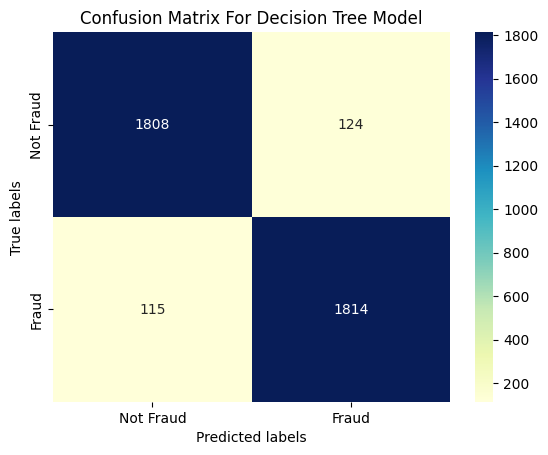

In [ ]:
# Predict with testing data and visualize performance with confusion matrix
yhatTree = tree_cv.predict(Xtest)
plot_confusion_matrix(Ytest, yhatTree, "Decision Tree")

With the few error cases we have, the amount of false negatives and positives is roughly the same. For our goals, we want to minimize the total amount of error cases with special focus on false negatives (meaning we would misclassify fraudulant transactions and miss them).

We can look at the classification report, which gives us another measure to look at model accuracy and a way to measure false positives/negatives.

In [ ]:
print(classification_report(Ytest, yhatTree))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1932
           1       0.94      0.94      0.94      1929

    accuracy                           0.94      3861
   macro avg       0.94      0.94      0.94      3861
weighted avg       0.94      0.94      0.94      3861



The overall accuracy of the model is at **0.94**, which we would like to maximize.

Based on the count of each section, we can also calculate precision and recall of each label:

*   **Precision** is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = $TP / (TP + FP)$. For our data set, it measures the proportion of classified fraudulant cases that were actually fraudulant.

*   **Recall** is the true positive rate. It is defined as: Recall = $ TP / (TP + FN)$. For our data set, it measures the proportion of the fraud cases that were correctly classified as fraudulant.

We want to maximize the recall value to leave out as many missed fraud cases as possible while also maximizing the precision rate, as having too many false alarms is not ideal; Both can be costly mistakes.

**F1 score:**
The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. The formula is given below.

$TP / (TP + 0.5(FP + FN))$

It is a good way to show that a classifer has a good value for both recall and precision.

We can tell the average accuracy for this classifier by the average of the F1-score for both labels, which is around **0.94.** From this, we can tell that our model has an overall good fit.

To simplify analyzing model accuracy, we will focus on the overall accuracy of the model and the average F1 score, and see which model has the highest of these two values.

## **Logistic Regression**

In [ ]:
# provide dictionary of parameters that grid search can use to test with
parametersLogReg = {'C':[0.01,0.1,1],
 'penalty':['l2'],
 'solver':['lbfgs']}

# Initialize the Logistic Regression Classifier
lr = LogisticRegression(random_state = random_seed)

# Create the grid search object
grid_search_lr = GridSearchCV(lr, parametersLogReg, cv = 10)

# Fit the model using grid search
logreg_cv = grid_search_lr.fit(Xtrain, Ytrain)

# Print the best parameters found and the accuracy score
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8356975535322032


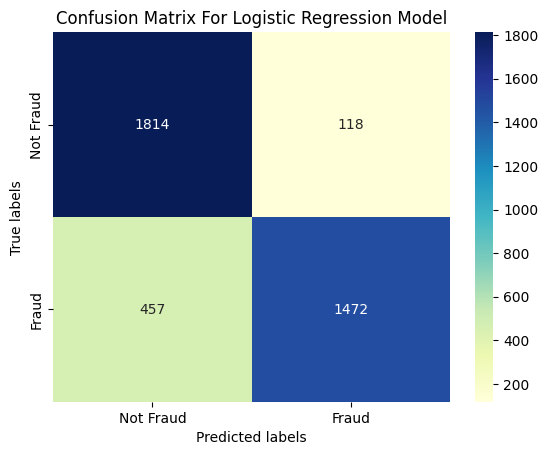

In [ ]:
# Predict with testing data and visualize performance with confusion matrix
yhatLogReg = logreg_cv.predict(Xtest)
plot_confusion_matrix(Ytest, yhatLogReg, "Logistic Regression")

Compared to the decision tree model, this has significantly more false negatives.

In [ ]:
print(classification_report(Ytest, yhatLogReg))

              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1932
           1       0.93      0.76      0.84      1929

    accuracy                           0.85      3861
   macro avg       0.86      0.85      0.85      3861
weighted avg       0.86      0.85      0.85      3861



The overall model accuracy is 0.86, and the average of the F-1 scores is 0.855, which is noticably lower than our decision tree model.

## **LDA**

In [ ]:
# Define the LDA model
lda = LinearDiscriminantAnalysis()

# Define the parameter grid
parametersLDA = {
    'solver': ['svd', 'lsqr', 'eigen'],  # Solver options for LDA
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]  # Shrinkage options (if applicable)
}

# Create the GridSearchCV object
grid_search_lda = GridSearchCV(lda, parametersLDA, cv=5, scoring='precision')

# Fit the model using grid search
lda_cv = grid_search_lda.fit(Xtrain, Ytrain)

# Print the best parameters found and the accuracy score
print("Best Parameters: ", lda_cv.best_params_)
print("Accuracy :", lda_cv.best_score_)

Best Parameters:  {'shrinkage': 'auto', 'solver': 'lsqr'}
Accuracy : 0.8704166929755092


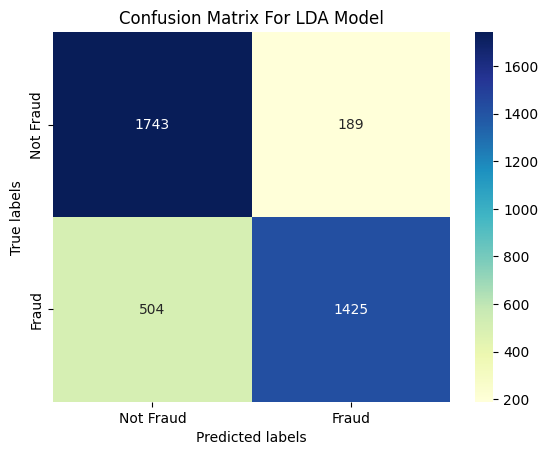

In [ ]:
# Predict with testing data and visualize performance with confusion matrix
yhatLDA = lda_cv.predict(Xtest)
plot_confusion_matrix(Ytest, yhatLDA, "LDA")

Out of the error cases, the majority are false negatives, which again, is not favorable.

In [ ]:
print(classification_report(Ytest, yhatLDA))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83      1932
           1       0.88      0.74      0.80      1929

    accuracy                           0.82      3861
   macro avg       0.83      0.82      0.82      3861
weighted avg       0.83      0.82      0.82      3861



The overall model accuracy and average of the F1 scores is around 0.81.

## **QDA**

In [ ]:
# Define the dictionary of parameters to optimize
parametersQDA = {
    'reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],  # Adjust as needed
}

# Initialize the QDA classifier
qda = QuadraticDiscriminantAnalysis()

# Create GridSearchCV object
grid_search_qda = GridSearchCV(qda, parametersQDA, cv=5, scoring='accuracy')

# Fit the model with grid search
qda_cv = grid_search_qda.fit(Xtrain, Ytrain)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", qda_cv.best_params_)
print("Accuracy :", qda_cv.best_score_)

Best Parameters:  {'reg_param': 0.4}
Accuracy : 0.851952461265698


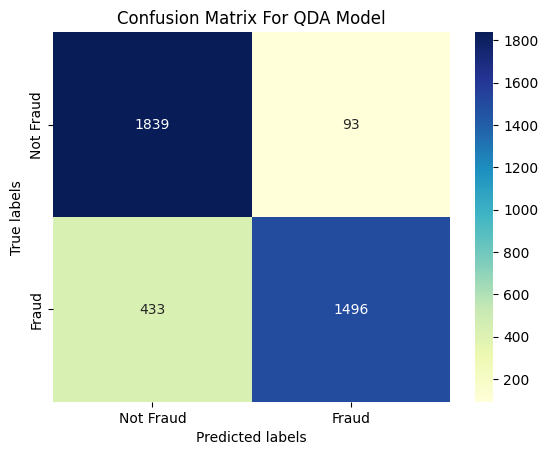

In [ ]:
# Predict with testing data and visualize performance with confusion matrix
yhatQDA = qda_cv.predict(Xtest)
plot_confusion_matrix(Ytest, yhatQDA, "QDA")

This has similar results to the LDA model, with most of the error cases being false negatives.

In [ ]:
print(classification_report(Ytest, yhatQDA))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      1932
           1       0.94      0.78      0.85      1929

    accuracy                           0.86      3861
   macro avg       0.88      0.86      0.86      3861
weighted avg       0.88      0.86      0.86      3861



The overall model accuracy and average of the F1 scores is around 0.84.

## **Support Vector Machine (SVM)**

This algorithm is quite simple conceptually. The goal is to take our dataset, and use a kernal function to convert the (most likely) non linear relationship of our data into a linear format. From here, we want to be able to define a hyperplane to divide up the datapoints based on the classes. However, this is only ideal for smaller datasets, as model complexity increases quickly based on the number of features in our dataset. So, we will avoid running grid search for this algorithm.

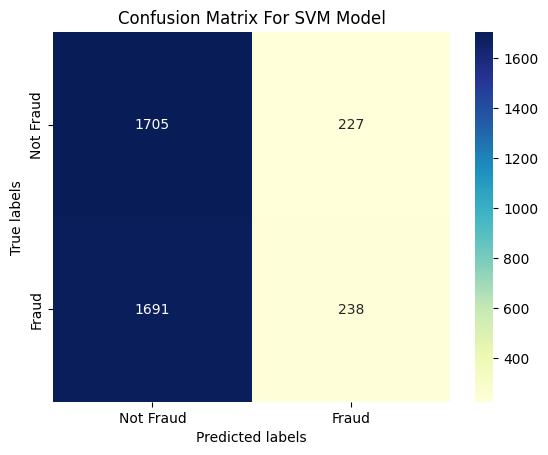

In [ ]:
# Create support vector machine classifier
# Parameter of probability=True will save prediction probabilities, which we need for later
svm = SVC(kernel='rbf', random_state = random_seed, probability = True)

# Fit the model with the SVM classifier created above
svmModel = svm.fit(Xtrain, Ytrain)

# Predict with our testing data
yhatSVM = svmModel.predict(Xtest)

# Visualize performance with confusion matrix
plot_confusion_matrix(Ytest, yhatSVM, "SVM")

It appears that this is the worst model so far, where the majority of the fraudulant cases are incorrectly misclassified as non fraudulant.

In [ ]:
print(classification_report(Ytest, yhatSVM))

              precision    recall  f1-score   support

           0       0.50      0.88      0.64      1932
           1       0.51      0.12      0.20      1929

    accuracy                           0.50      3861
   macro avg       0.51      0.50      0.42      3861
weighted avg       0.51      0.50      0.42      3861



Following on our initial observations, the overall model accuracy and the average F1 score is under 0.5, indicating a terrible fit, which is not surprising given the dimension of our data.

## **KNN**

In [ ]:
# Define the dictionary of parameters to optimize
parametersKNN = {'n_neighbors': [3, 4, 5, 6, 7], # number of nearest neighbors
 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], #algorithms to find the closest neighbors
 'p': [1]} # determining which distance formula to use; manhattan_distance (1), euclidian distance (2)

# Manhattan distance is usually preferred over the more common Euclidean distance
# when there is high dimensionality in the data, which we have in our data.

# Create the K Nearest Neighbors Classifier
KNN = KNeighborsClassifier()

# Create grid search obhject
grid_search_knn = GridSearchCV(KNN, parametersKNN, cv=10)

# Fit the model with grid search and print the best parameters with model accuracy
knn_cv = grid_search_knn.fit(Xtrain, Ytrain)
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.8752669064506934


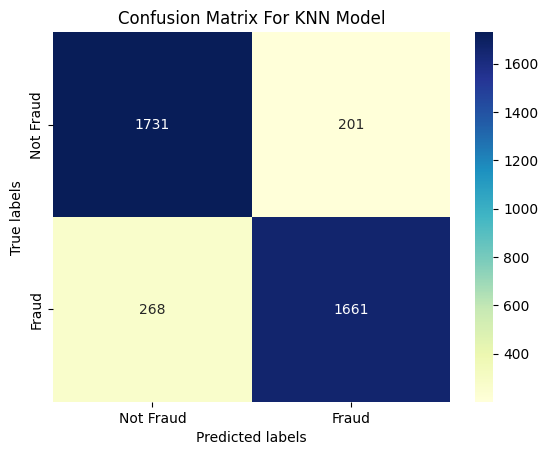

In [ ]:
# Predict with testing data and visualize performance with confusion matrix
yhatKNN = knn_cv.predict(Xtest)
plot_confusion_matrix(Ytest, yhatKNN, "KNN")

The overall performance of the model appears to look much better versus the SVM model.

In [ ]:
print(classification_report(Ytest, yhatKNN))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1932
           1       0.89      0.86      0.88      1929

    accuracy                           0.88      3861
   macro avg       0.88      0.88      0.88      3861
weighted avg       0.88      0.88      0.88      3861



The overall model accuracy and average F1 score is around 0.88.

## **Random Forest**

Random Forest operates by constructing multiple decision trees during training and outputting the class that is the most frequent of the classes (classification)



In [ ]:
parametersForest = {'criterion': ['gini'],
              'max_depth':[None],
              'n_estimators':[100],
              'max_features':[3, 5, 7],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }

# Create the RandomForestClassifier
randomForest = RandomForestClassifier(random_state = random_seed)

# Create GridSearchCV object
# reducing the cv down to 5 to reduce computing time
grid_search_Forest = GridSearchCV(randomForest, parametersForest, cv=5)
# We reduce cv from 10 to 5 to reduce computing time

# Fit the model with grid search
randomForest_cv = grid_search_Forest.fit(Xtrain, Ytrain)

# Print the best parameters and corresponding accuracy
print("tuned hpyerparameters :(best parameters) ", randomForest_cv.best_params_)
print("accuracy :", randomForest_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
accuracy : 0.9773977359072894


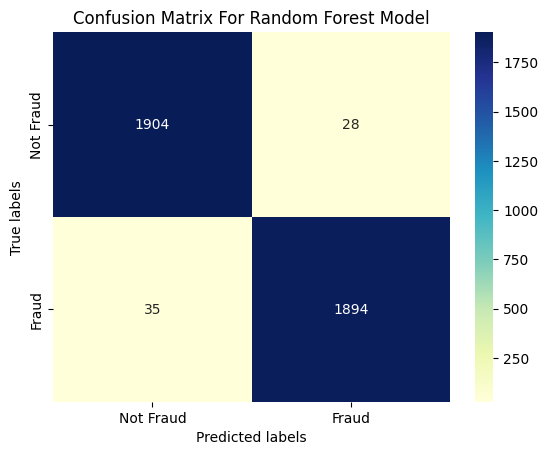

In [ ]:
# Predict with testing data and output results with confusion matrix
yhatForest = randomForest_cv.predict(Xtest)
plot_confusion_matrix(Ytest, yhatForest, "Random Forest")

In [ ]:
print(classification_report(Ytest, yhatForest))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1932
           1       0.99      0.98      0.98      1929

    accuracy                           0.98      3861
   macro avg       0.98      0.98      0.98      3861
weighted avg       0.98      0.98      0.98      3861



This is the highest set of scores so far, with the overall model accuracy and the average F1 scores is around 0.98.

## **Neural Network**

Neural Network are structured like the human brain. It is organized in
connected nodes arranged in layers. Each one of these nodes in these layers recieve an input and processes it and produces an output.

This is another algorithm that has a high level of model complexity, especially with a larger dataset, so we do not run grid search on it.

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xtrain)
X_test_scaled = scaler.transform(Xtest)

# Define the neural network model
nnModel = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
nnModel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
nnModel.fit(X_train_scaled, Ytrain, epochs=10, batch_size=32)

121/121 [==============================] - 0s 2ms/step


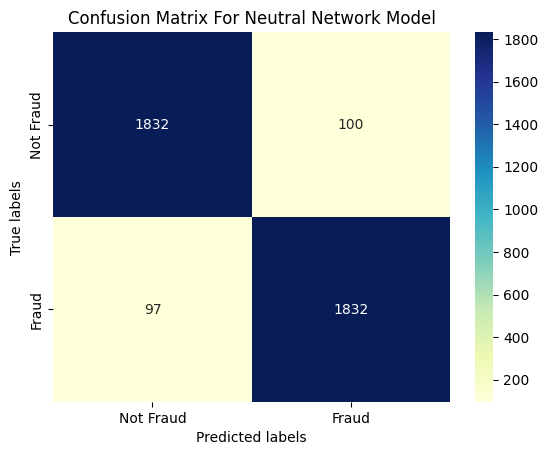

In [ ]:
# Predict with testing data and output results as a confusion matrix
yhatNN = nnModel.predict(X_test_scaled)
# Convert probabilities to classes
yhatNN = (yhatNN > 0.5).astype(int)
plot_confusion_matrix(Ytest, yhatNN, "Neutral Network")

The overall performance seems to be pretty well, but certaintly not as well as the random forest model.

In [ ]:
print(classification_report(Ytest, yhatNN))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1932
           1       0.96      0.93      0.95      1929

    accuracy                           0.95      3861
   macro avg       0.95      0.95      0.95      3861
weighted avg       0.95      0.95      0.95      3861



Now looking at the specific metrics, the performance is great but a little bit worse compared to the random forest model, with an average F1 score and model accuracy of around 0.95.

## **XGBoost**

 XGBoost builds a series of decision trees sequentially, with each subsequent tree focusing on the examples that the previous trees failed to predict accurately. This iterative process allows the model to gradually improve its predictions.

In [ ]:
# Initialize XGBoost model
xgBoost = xgb.XGBClassifier(objective='binary:logistic', random_state = random_seed)

# Define the parameter grid to search
parametersXGBoost = {
    'n_estimators': [100, 200, 300],  # Adjust as needed
    'max_depth': [3, 5, 7],  # Adjust as needed
    'learning_rate': [0.01, 0.1, 0.2],  # Adjust as needed
    'subsample': [0.8, 1.0],  # Adjust as needed
}

# Create GridSearchCV object
grid_search_xgB = GridSearchCV(xgBoost, parametersXGBoost, cv=5, scoring='accuracy')

# Fit the model with grid search
xgB_cv = grid_search_xgB.fit(Xtrain, Ytrain)

# Print the best parameters and corresponding accuracy
print("tuned hpyerparameters :(best parameters) ", xgB_cv.best_params_)
print("accuracy :", xgB_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
accuracy : 0.9797294259926164


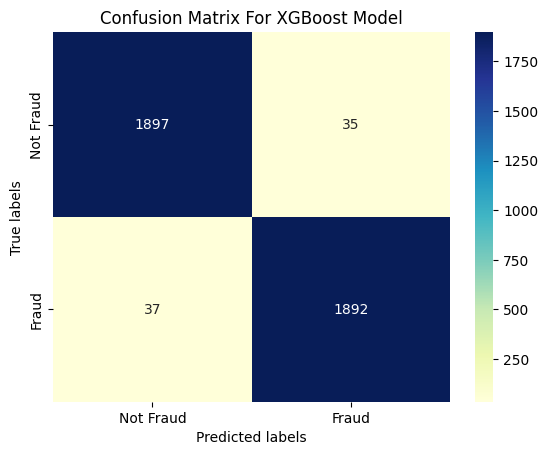

In [ ]:
# Predict with testing data and output results into confusion matrix
yhatxgB = xgB_cv.predict(Xtest)
plot_confusion_matrix(Ytest, yhatxgB, "XGBoost")

We can see that this has very similar results to the random forest model.

In [ ]:
print(classification_report(Ytest, yhatxgB))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1932
           1       0.98      0.98      0.98      1929

    accuracy                           0.98      3861
   macro avg       0.98      0.98      0.98      3861
weighted avg       0.98      0.98      0.98      3861



Repeated from the confusion matrix, this has very similar performance results to the random forest algorithm, where the average model performance and F1 scores is around 0.98.

# Part 3: Conclusions

To determine the best model to choose, we look at each of the ROC curves, which allows us to easily compare model performance (compared to looking back at each of the confusion matrices).

Recall that the curves are obtained by computing the false and true positive rates for a range of values for each of our features. The optimal curve will hug the left corner, which maximizes the true positive rate and minimizes the false positive rate. We focus on the corresponding area under the curve (AUC), which we would want to maximize up to a value of 1.00.

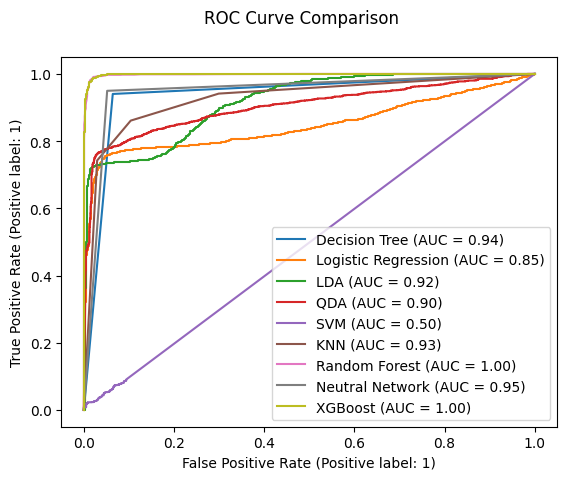

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

rocPlots = RocCurveDisplay.from_estimator(tree_cv, Xtest, Ytest, name = "Decision Tree")
rocPlots = RocCurveDisplay.from_estimator(logreg_cv, Xtest, Ytest, name = "Logistic Regression", ax = rocPlots.ax_)
rocPlots = RocCurveDisplay.from_estimator(lda_cv, Xtest, Ytest, name = "LDA", ax = rocPlots.ax_)
rocPlots = RocCurveDisplay.from_estimator(qda_cv, Xtest, Ytest, name = "QDA", ax = rocPlots.ax_)
rocPlots = RocCurveDisplay.from_estimator(svmModel, Xtest, Ytest, name = "SVM", ax = rocPlots.ax_)
rocPlots = RocCurveDisplay.from_estimator(knn_cv, Xtest, Ytest, name = "KNN", ax = rocPlots.ax_)
rocPlots = RocCurveDisplay.from_estimator(randomForest_cv, Xtest, Ytest, name = "Random Forest", ax = rocPlots.ax_)
rocPlots = RocCurveDisplay.from_predictions(Ytest, yhatNN, name = "Neutral Network", ax = rocPlots.ax_)
rocPlots = RocCurveDisplay.from_estimator(xgB_cv, Xtest, Ytest, name = "XGBoost", ax = rocPlots.ax_)

rocPlots.figure_.suptitle("ROC Curve Comparison")
plt.show()

From our ROC curves, we can see that both the random forest and XGBoost algorithms are the best, with an AUC of 1.00. For future analysis, it could be worthwhile to consider algorithms with overall good performance that are faster, since random forest and XGBoost are not the quickest, and a fastest algorithm may be preferred.